In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime, os, json

from collections import Counter

import tensorflow as tf

2023-07-04 21:38:59.518149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
configs = json.load(open('configs.json'))
path = configs['path']
ticker = 'BTC-USD'

In [3]:
def get_time_range(start, steps, step_size, range_type='day', string=True):
    start = datetime.datetime.strptime(start, '%Y-%m-%d')
    time_range = [start + datetime.timedelta(days=x) for x in range(0, steps, step_size)]
    if string is True:
        time_range = [t.strftime('%Y-%m-%d') for t in time_range]
    return time_range

In [74]:
def pull_data(path, ticker, day_chunks=7, offset=30, max_days=30):
    col_names = ['open', 'high', 'low', 'close', 'volume', 'time_step', 'time']
    
    filepath_old = os.path.join(path, 'old', ticker.replace('-', '').lower())+'.csv'
    filepath_new = os.path.join(path, 'yfinance', ticker.lower()+'.csv')
    
    data_old = pd.read_csv(filepath_old)
    rounding = 60000
    data_old['time_step'] = pd.to_datetime(rounding * (np.round(data_old['time']/rounding)).astype(int) * 1000000)
    data_old = data_old.loc[:, col_names]
    
    ticker_obj = yf.Ticker(ticker) # pull ticker data from yahoo finance
    
    start = (datetime.datetime.now()-datetime.timedelta(days=offset-2)).strftime('%Y-%m-%d')
    
    time_range = get_time_range(start, max_days, 1)
    for t in range(int(np.ceil(len(time_range)/(day_chunks-1)))):
        my_range = time_range[(day_chunks*t):min(len(time_range),1+(day_chunks*(t+1)))]
        data_new = ticker_obj.history(period='7d', interval='1m', start=min(my_range), end=max(my_range))
        if t == 0:
            data_new_all = data_new
        else:
            data_new_all = pd.concat([data_new_all, data_new], axis=0)

    data_new_all = data_new_all.reset_index()
    
    data_new_all = data_new_all[['Open', 'Close', 'High', 'Low', 'Volume', 'Datetime']]
    
    data_new_all['Datetime'] = data_new_all['Datetime'].apply(lambda x: x.round(freq='T').replace(tzinfo=None))
    data_new_all['time'] = data_new_all['Datetime'].astype(int)/1000000
    data_new_all.columns = col_names
    
    try:
        yt_existing = pd.read_csv('data/yfinance/btc-usd.csv')
        data_new_all = pd.concat([yt_existing, data_new_all], axis=0).drop_duplicates(subset='time_step', keep='first')
    except:
        pass
    
    data_new_all.to_csv(filepath_new, index=False)

    data_final = pd.concat([data_old, data_new_all], axis=0).drop_duplicates(subset='time_step', keep='first')
    
    return data_final 

In [78]:
pd.read_csv('data/yfinance/btc-usd.csv')

,open,high,low,close,volume,time_step,time
0,27123.109375,27123.109375,27123.109375,27123.109375,0,2023-06-05 00:00:00,1.685923e+12
1,27104.123047,27104.123047,27104.123047,27104.123047,5883904,2023-06-05 00:01:00,1.685923e+12
2,27099.457031,27099.457031,27099.457031,27099.457031,0,2023-06-05 00:02:00,1.685923e+12
3,27074.701172,27074.701172,27074.701172,27074.701172,0,2023-06-05 00:03:00,1.685923e+12
4,27101.470703,27101.470703,27101.470703,27101.470703,7531520,2023-06-05 00:04:00,1.685923e+12
...,...,...,...,...,...,...,...
82437,30515.654297,30515.654297,30515.654297,30515.654297,0,2023-07-05 17:45:00,1.688579e+12
82438,30519.714844,30519.714844,30519.714844,30519.714844,0,2023-07-05 17:46:00,1.688579e+12
82439,30519.187500,30519.187500,30519.187500,30519.187500,0,2023-07-05 17:47:00,1.688579e+12
82440,30518.490234,30518.490234,30518.490234,30518.490234,0,2023-07-05 17:48:00,1.688579e+12


In [5]:
def step_calc(first_date, last_date, group, group_mult):
    delta = last_date - first_date
    day_diff_frac = np.abs(delta.days + (delta.seconds/(60*60*24)))
    if group == 'day':
        steps = int(np.ceil(day_diff_frac)+1)
        intervals = pd.DataFrame(np.array([first_date + datetime.timedelta(days=x) for x in range(0, steps, group_mult)]), columns=['time_step'])
    elif group == 'hour':
        steps = int(np.ceil(day_diff_frac*24)+1)
        intervals = pd.DataFrame(np.array([first_date + datetime.timedelta(hours=x) for x in range(0, steps, group_mult)]), columns=['time_step'])
    elif group == 'minute':
        steps = int(np.ceil(day_diff_frac*24*60)+1)
        intervals = pd.DataFrame(np.array([first_date + datetime.timedelta(minutes=x) for x in range(0, steps, group_mult)]), columns=['time_step'])
    return intervals

In [76]:
def prepare_data(path, ticker, group='minute', group_mult=1, fill_intervals=True, lookbacks=[2, 3, 5, 7, 14, 20, 30, 90, 365]):
    data = pull_data(path, ticker)
    data = data.sort_values(by='time')

    interval_data = {
        'second': [1000, '%Y-%m-%d %H:%M:%S'], # one second - don't have data this granular just yet :)
        'minute': [1000*60, '%Y-%m-%d %H:%M'],
        'hour':   [1000*60*60, '%Y-%m-%d %H'],
        'day':    [1000*60*60*24, '%Y-%m-%d'],
        'week':   [1000*60*60*24*7,'%Y-%m-%d']
    }
    
    interval = interval_data[group][0]
    
    # the rounding helps us bunch minutes, hours and days into steps of more than 1 minute if we desire...
    if (group != 'minute') or (group_mult != 1):
        rounding = (interval_data[group][0] * group_mult)
        data['time_step'] = pd.to_datetime(rounding * (np.round(data['time']/rounding)).astype(int) * 1000000)

    if group != 'day': data['date'] = data['time_step'].dt.strftime('%Y-%m-%d')
    data['time_step'] = data['time_step'].dt.strftime(interval_data[group][1])
    data_open = data[['time_step', 'open']].drop_duplicates(subset='time_step', keep='first').reset_index(drop=True)
    data_close = data[['time_step', 'close']].drop_duplicates(subset='time_step', keep='last').reset_index(drop=True)
    data_high = data[['time_step', 'high']].groupby(by='time_step').max().reset_index()
    data_low = data[['time_step', 'low']].groupby(by='time_step').min().reset_index()
    data_volume = data[['time_step', 'volume']].groupby(by='time_step').sum().reset_index()

    data = pd.concat([data_open, data_close[['close']], data_high[['high']], data_low[['low']], data_volume[['volume']]], axis=1)

    min_time = min(data['time_step'])
    max_time = max(data['time_step'])
    
    # fill_intervals (optional)
    if fill_intervals is True:
        first_date = datetime.datetime.strptime(min_time, interval_data[group][1])
        last_date = datetime.datetime.strptime(max_time, interval_data[group][1])
        intervals = step_calc(first_date, last_date, group, group_mult) # np.abs((last_date-first_date).days)+1
        intervals['time'] = intervals['time_step'].apply(lambda x: int(1000*x.timestamp()))
        intervals['time_step'] = intervals['time_step'].dt.strftime(interval_data[group][1])

        intervals.index = intervals['time']
        
        data = pd.merge(data, intervals, how='right', on='time_step')

        data['idx_prev'] = np.where(data['open'].isna(), np.nan, data['time'])
        data['idx_next'] = data['idx_prev'] # data['time']
        
        for c in ['open', 'close', 'high', 'low', 'volume']: data[c] = data[c].ffill().bfill()
        
        data['idx_prev'] = (data['time']-data['idx_prev'].ffill().bfill())/interval
        data['idx_next'] = (data['idx_next'].bfill().ffill()-data['time'])/interval

        # how far from a real value are the (naively) extrapolated ones? This is a data quality lever for use later
        data['dist_extrapolated'] = np.abs(data[['idx_prev']].astype('int64'))

        for t in lookbacks:
            data[str(t)+'_period_lookback'] = data['dist_extrapolated'].rolling(t).max()
            data[str(t)+'_period_lookback'] = np.minimum(data[str(t)+'_period_lookback'], 1)

    # data['time2'] = data['time'].shift(1)

    return data

In [77]:
# btc_minute = pull_data(path, 'btcusd', group='minute')
# my_data = prepare_data(path, ticker, group='hour', group_mult=1, lookbacks=[2, 4, 6, 12, 24, 48, 72, 96, 168])
my_minute_data = prepare_data(path, ticker, group='minute', group_mult=5, lookbacks=[2, 4, 6, 12, 24, 48, 72, 96, 120, 240])
# btc_daily = pull_data(path, 'btcusd', group='day')

In [12]:
my_data

,time_step,open,close,high,low,volume,time,idx_prev,idx_next,dist_extrapolated,2_period_lookback,4_period_lookback,6_period_lookback,12_period_lookback,24_period_lookback,48_period_lookback,72_period_lookback,96_period_lookback,168_period_lookback
0,2013-04-01 00,93.250000,93.350000,100.000000,93.030000,2.649734e+02,1364774400000,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-01 01,93.199990,93.400010,93.487970,93.100000,1.235811e+02,1364778000000,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-04-01 02,93.100010,93.109990,93.290000,93.100000,1.333415e+01,1364781600000,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-01 03,93.240000,92.500000,94.000000,92.499990,5.365662e+02,1364785200000,0.0,0.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-04-01 04,92.700020,93.155030,93.155030,92.700020,2.000000e+01,1364788800000,0.0,0.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89900,2023-07-03 20,31344.345703,31235.626953,31375.613281,31182.519531,1.312377e+09,1688414400000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89901,2023-07-03 21,31221.589844,31011.560547,31226.878906,30960.898438,9.812347e+08,1688418000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89902,2023-07-03 22,31038.126953,31122.572266,31124.326172,31006.640625,8.527360e+08,1688421600000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89903,2023-07-03 23,31140.972656,31117.599609,31140.972656,31099.277344,6.137897e+08,1688425200000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
my_minute_data

,time_step,open,close,high,low,volume,time,idx_prev,idx_next,dist_extrapolated,2_period_lookback,4_period_lookback,6_period_lookback,12_period_lookback,24_period_lookback,48_period_lookback,72_period_lookback,96_period_lookback,120_period_lookback,240_period_lookback
0,2013-04-01 00:07,93.250000,93.300000,93.300000,93.250000,93.300000,1364774820000,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-01 00:12,93.470000,93.470000,93.470000,93.470000,2.021627,1364775120000,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-04-01 00:17,93.470000,93.470000,93.470000,93.470000,2.021627,1364775420000,5.0,50.0,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-01 00:22,93.470000,93.470000,93.470000,93.470000,2.021627,1364775720000,10.0,45.0,10,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-04-01 00:27,93.470000,93.470000,93.470000,93.470000,2.021627,1364776020000,15.0,40.0,15,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079130,2023-07-04 23:37,30818.099609,30818.099609,30818.099609,30818.099609,0.000000,1688513820000,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1079131,2023-07-04 23:42,30813.851562,30813.851562,30813.851562,30813.851562,82944.000000,1688514120000,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1079132,2023-07-04 23:47,30818.626953,30818.626953,30818.626953,30818.626953,0.000000,1688514420000,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1079133,2023-07-04 23:52,30788.339844,30788.339844,30788.339844,30788.339844,0.000000,1688514720000,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
my_data[my_data['168_period_lookback']==0]

,time_step,open,close,high,low,volume,time,idx_prev,idx_next,dist_extrapolated,2_period_lookback,4_period_lookback,6_period_lookback,12_period_lookback,24_period_lookback,48_period_lookback,72_period_lookback,96_period_lookback,168_period_lookback
179,2013-04-08 11,180.360000,183.801000,183.850000,180.000000,3.330126e+02,1365418800000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,2013-04-08 12,184.645000,186.000000,187.188000,182.678000,4.919985e+02,1365422400000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,2013-04-08 13,187.447000,188.950000,191.000000,187.447000,4.042807e+02,1365426000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,2013-04-08 14,188.950000,192.599000,192.599000,188.500000,1.144140e+03,1365429600000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,2013-04-08 15,193.100000,189.000000,194.570000,185.000000,1.221312e+03,1365433200000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89900,2023-07-03 20,31344.345703,31235.626953,31375.613281,31182.519531,1.312377e+09,1688414400000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89901,2023-07-03 21,31221.589844,31011.560547,31226.878906,30960.898438,9.812347e+08,1688418000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89902,2023-07-03 22,31038.126953,31122.572266,31124.326172,31006.640625,8.527360e+08,1688421600000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89903,2023-07-03 23,31140.972656,31117.599609,31140.972656,31099.277344,6.137897e+08,1688425200000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [219]:
my_minute_data[my_minute_data['240_period_lookback']==0]

,time_step,open,close,high,low,volume,time,idx_prev,idx_next,dist_extrapolated,2_period_lookback,4_period_lookback,6_period_lookback,12_period_lookback,24_period_lookback,48_period_lookback,72_period_lookback,96_period_lookback,120_period_lookback,240_period_lookback
188361,2015-01-15 00:52,187.340000,186.740000,187.740000,186.500000,119.399504,1421283120000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188362,2015-01-15 00:57,189.480000,188.560000,189.530000,188.560000,49.661785,1421283420000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188363,2015-01-15 01:02,191.110000,190.400000,192.000000,190.000000,282.101269,1421283720000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188364,2015-01-15 01:07,194.000000,194.990000,195.000000,193.000000,81.422325,1421284020000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188365,2015-01-15 01:12,194.150000,194.460000,194.850000,193.050000,77.083314,1421284320000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078186,2023-07-01 16:57,30581.714844,30581.714844,30581.714844,30581.714844,0.000000,1688230620000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1078187,2023-07-01 17:02,30568.677734,30568.677734,30568.677734,30568.677734,0.000000,1688230920000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1078188,2023-07-01 17:07,30578.888672,30578.888672,30578.888672,30578.888672,0.000000,1688231220000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1078189,2023-07-01 17:12,30583.326172,30583.326172,30583.326172,30583.326172,0.000000,1688231520000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **RSI Calc**

In [8]:
def make_rsi(data, t):
    data['prev'] = data['open'].shift(1)
    data['gain'] = np.maximum(data['open']-data['prev'], 0)
    data['loss'] = np.maximum(data['prev']-data['open'], 0)

    data['avg_gain_'+str(t)] = data['gain'].rolling(t).mean()
    data['avg_loss_'+str(t)] = data['loss'].rolling(t).mean()
    
    data['RS'] = data['avg_gain_'+str(t)]/data['avg_loss_'+str(t)]
    data['RSI'] = data['RS'].apply(lambda x: 100-(100/(1+x)))
    
    return data

#### **Stochastic Calc**

##### %k = (Last Closing Price – Lowest Price)/(Highest Price – Lowest Price) x 100

##### %D = 3-day SMA of %K

In [9]:
def make_stochastic(data, t):
    data['prev'] = data['close'].shift(1)
    
    data['high_'+str(t)] = data['high'].rolling(t).max()
    data['low_'+str(t)] = data['low'].rolling(t).min()    

    data['Stochastic'] = data.apply(lambda r: 100 if r['high_'+str(t)]==r['low_'+str(t)] else 100*(r['prev']-r['low_'+str(t)])/(r['high_'+str(t)]-r['low_'+str(t)]), axis=1)
    data['Stochastic_3_Avg'] = data['Stochastic'].rolling(3).mean()
    
    return data

#### **Williams %R Calc**

In [10]:
def make_williams_r(data, t):
    data['prev'] = data['close'].shift(1)
    
    data['high_'+str(t)] = data['high'].rolling(t).max()
    data['low_'+str(t)] = data['low'].rolling(t).min()    

    data['Williams %R'] = data.apply(lambda r: -100 if r['high_'+str(t)]==r['low_'+str(t)] else -100*(r['high_'+str(t)]-r['prev'])/(r['high_'+str(t)]-r['low_'+str(t)]), axis=1)
    
    return data

#### **Bollinger Bands**

In [11]:
def make_bollinger(data, t, n):
    data['typical'] = (data['high'] + data['low'] + data['close'])/3
    data['sd'] = data['typical'].rolling(t).std()
    
    data['BOLU'] = data['typical'].rolling(t).mean() + (n * data['sd'])
    data['BOLD'] = data['typical'].rolling(t).mean() - (n * data['sd'])
    
    return data

In [12]:
# Keltner Channel Middle Line = EMA
# Keltner Channel Upper Band = EMA+2∗ATR
# Keltner Channel Lower Band = EMA−2∗ATR

#### **Keltner Channels**

In [13]:
def make_keltner(data, t, t2, smoothing):

    multiplier = smoothing/(1+t)
    
    ema = [data['close'][0]*multiplier]
    for i in range(1, len(data)):
        ema.append((data['close'][i]*multiplier)+(ema[-1]*(1-multiplier)))

    data['prev'] = data['close'].shift(1)
    data['tr'] = data.apply(lambda r: max(r['high']-r['low'], np.abs(r['high']-r['close']), np.abs(r['low']-r['close'])), axis=1)

    data['atr'] = data['tr'].rolling(t2).mean()

    data['keltner'] = ema
    data['keltner_upper'] = data['keltner']+(2*data['atr'])
    data['keltner_lower'] = data['keltner']-(2*data['atr'])

    data['keltner_coeff'] = data.apply(lambda r: 50 if r['keltner_upper']==r['keltner_lower'] else (r['open']-r['keltner_lower'])/(r['keltner_upper']-r['keltner_lower']), axis=1)
    data['keltner_coeff'] = data.apply(lambda x: np.nan if str(x['keltner_coeff']) == 'nan' else max(0, min(1, x['keltner_coeff']))*100, axis=1)
    data['keltner_coeff'] = data['keltner_coeff'].rolling(20).mean()
    
    return data

In [14]:
def add_indicators(data):
    data = make_rsi(data, 14)
    data = make_stochastic(data, 14)
    data = make_williams_r(data, 14)
    data = make_bollinger(data, 20, 2)
    data = make_keltner(data, 20, 10, 2)
    return data

In [306]:
my_data = add_indicators(my_data)

In [15]:
my_minute_data = add_indicators(my_minute_data)

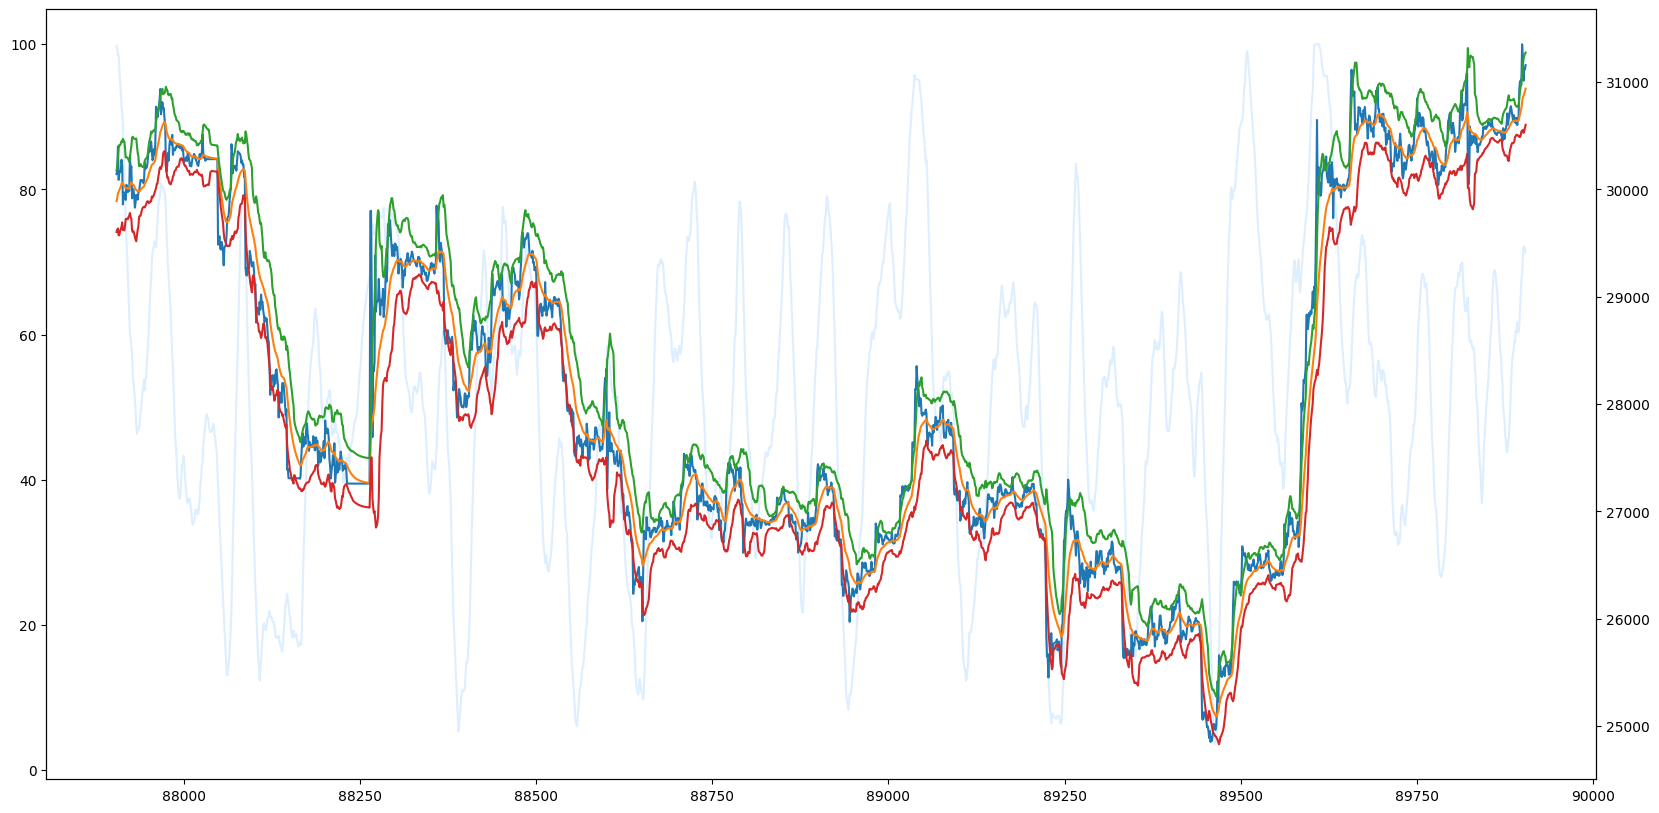

In [115]:
plt.rcParams['figure.figsize'] = [20, 10]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(my_data[-2000:]['keltner_coeff'], color='#DEF')
ax2.plot(my_data[-2000:]['close'])
ax2.plot(my_data[-2000:]['keltner'])
ax2.plot(my_data[-2000:]['keltner_upper'])
ax2.plot(my_data[-2000:]['keltner_lower'])

#### **My own indicators**

In [16]:
def add_my_indicators(data):
    time_deltas = [2, 6, 12, 24, 48, 72, 96, 168] #, 720, 1440, 2880, 4320]

    for t in time_deltas:
        data['price_prev_'+str(t)+'_hours'] = data['high'].shift(t)
        data['price_diff_'+str(t)+'_hours'] = data['high']-data['price_prev_'+str(t)+'_hours']
        data['price_velocity_'+str(t)+'_hours'] = (data['high']-data['price_prev_'+str(t)+'_hours'])/data['price_prev_'+str(t)+'_hours']

    return data

In [234]:
my_data = add_my_indicators(my_data)

In [17]:
my_minute_data = add_my_indicators(my_minute_data)

In [120]:
my_data

,time_step,open,close,high,low,volume,time,idx_prev,idx_next,dist_extrapolated,...,price_diff_72_mins,price_velocity_72_mins,price_prev_96_mins,price_diff_96_mins,price_velocity_96_mins,price_prev_168_mins,price_diff_168_mins,price_velocity_168_mins,max_168_hour,target
0,2013-04-01 00,93.250000,93.350000,100.000000,93.030000,2.649734e+02,1364774400000,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2013-04-01 01,93.199990,93.400010,93.487970,93.100000,1.235811e+02,1364778000000,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2013-04-01 02,93.100010,93.109990,93.290000,93.100000,1.333415e+01,1364781600000,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2013-04-01 03,93.240000,92.500000,94.000000,92.499990,5.365662e+02,1364785200000,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2013-04-01 04,92.700020,93.155030,93.155030,92.700020,2.000000e+01,1364788800000,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89900,2023-07-03 20,31344.345703,31235.626953,31375.613281,31182.519531,1.312377e+09,1688414400000,0.0,0.0,0,...,879.523438,0.028841,30632.925781,742.687500,0.024245,30312.349609,1063.263672,0.035077,31375.613281,0
89901,2023-07-03 21,31221.589844,31011.560547,31226.878906,30960.898438,9.812347e+08,1688418000000,0.0,0.0,0,...,740.464844,0.024288,30422.300781,804.578125,0.026447,30220.951172,1005.927734,0.033286,31375.613281,0
89902,2023-07-03 22,31038.126953,31122.572266,31124.326172,31006.640625,8.527360e+08,1688421600000,0.0,0.0,0,...,599.257812,0.019632,30447.185547,677.140625,0.022240,30219.021484,905.304688,0.029958,31375.613281,0
89903,2023-07-03 23,31140.972656,31117.599609,31140.972656,31099.277344,6.137897e+08,1688425200000,0.0,0.0,0,...,630.896484,0.020678,30467.275391,673.697266,0.022112,30255.283203,885.689453,0.029274,31375.613281,0


In [174]:
my_data['max_168_hour'] = my_data['high'].rolling(168).max().shift(-1)
my_data['min_168_hour'] = my_data['low'].rolling(168).min().shift(-1)

In [18]:
my_minute_data['max_240_period'] = my_minute_data['high'].rolling(240).max().shift(-1)
my_minute_data['min_240_period'] = my_minute_data['low'].rolling(240).min().shift(-1)

In [175]:
my_data['target'] = np.where(my_data['max_168_hour'] >= my_data['high']*1.05, 1, 0)
my_data['target'] = np.where(my_data['min_168_hour'] >= my_data['high']*0.95, my_data['target'], 0)

In [19]:
my_minute_data['target'] = np.where(my_minute_data['max_240_period'] >= my_minute_data['high']*1.02, 1, 0)
my_minute_data['target'] = np.where(my_minute_data['min_240_period'] >= my_minute_data['high']*0.95, my_minute_data['target'], 0)

In [378]:
# my_minute_data #[(my_minute_data['max_240_period'] >= my_minute_data['high']*1.02)][['high','max_240_period','min_240_period','target']]

In [176]:
my_data_subset = my_data[my_data['168_period_lookback']==0].reset_index(drop=True)

In [20]:
my_minute_data_subset = my_minute_data[my_minute_data['240_period_lookback']==0].reset_index(drop=True)

In [321]:
sum(my_data_subset['target'])

15984

In [21]:
sum(my_minute_data_subset['target'])

136585

In [22]:
window_size = 240 # 168

In [23]:
cols_remove = ['open', 'high', 'low', 'time', 'time_step', 'idx_prev', 'idx_next', 'dist_extrapolated', 'max_168_hour',
               '2_period_lookback', '4_period_lookback', '6_period_lookback', '12_period_lookback', '24_period_lookback',
               '48_period_lookback', '72_period_lookback', '96_period_lookback', '120_period_lookback', '240_period_lookback', 'volume']
cols_keep = [c for c in list(my_minute_data_subset.columns) if c not in cols_remove]

In [24]:
cols_keep

['close',
 'prev',
 'gain',
 'loss',
 'avg_gain_14',
 'avg_loss_14',
 'RS',
 'RSI',
 'high_14',
 'low_14',
 'Stochastic',
 'Stochastic_3_Avg',
 'Williams %R',
 'typical',
 'sd',
 'BOLU',
 'BOLD',
 'tr',
 'atr',
 'keltner',
 'keltner_upper',
 'keltner_lower',
 'keltner_coeff',
 'price_prev_2_hours',
 'price_diff_2_hours',
 'price_velocity_2_hours',
 'price_prev_6_hours',
 'price_diff_6_hours',
 'price_velocity_6_hours',
 'price_prev_12_hours',
 'price_diff_12_hours',
 'price_velocity_12_hours',
 'price_prev_24_hours',
 'price_diff_24_hours',
 'price_velocity_24_hours',
 'price_prev_48_hours',
 'price_diff_48_hours',
 'price_velocity_48_hours',
 'price_prev_72_hours',
 'price_diff_72_hours',
 'price_velocity_72_hours',
 'price_prev_96_hours',
 'price_diff_96_hours',
 'price_velocity_96_hours',
 'price_prev_168_hours',
 'price_diff_168_hours',
 'price_velocity_168_hours',
 'max_240_period',
 'min_240_period',
 'target']

In [25]:
raw_train_data = my_minute_data_subset.iloc[window_size:-window_size, :].loc[:, cols_keep].sample(frac=1).reset_index(drop=True)
raw_train_data_unshuffled = my_minute_data_subset.iloc[window_size:-window_size, :].loc[:, cols_keep].reset_index(drop=True)

In [26]:
raw_train_data_unshuffled

,close,prev,gain,loss,avg_gain_14,avg_loss_14,RS,RSI,high_14,low_14,...,price_velocity_72_hours,price_prev_96_hours,price_diff_96_hours,price_velocity_96_hours,price_prev_168_hours,price_diff_168_hours,price_velocity_168_hours,max_240_period,min_240_period,target
0,441.120000,437.960000,2.000000,0.000000,1.176429,0.698571,1.684049,62.742857,446.430000,431.700000,...,0.021939,414.140000,26.980000,0.065147,417.500000,23.620000,0.056575,453.180000,382.020000,0
1,441.670000,441.120000,0.820000,0.000000,1.235000,0.592143,2.085645,67.591869,446.430000,434.320000,...,0.024467,415.880000,26.280000,0.063191,419.740000,22.420000,0.053414,453.180000,382.020000,0
2,441.090000,441.670000,0.000000,0.400000,1.057857,0.620714,1.704258,63.021277,446.430000,434.320000,...,0.027581,413.000000,28.860000,0.069879,420.000000,21.860000,0.052048,453.180000,382.020000,0
3,440.000000,441.090000,0.000000,2.370000,1.006429,0.790000,1.273960,56.023857,446.430000,435.740000,...,0.016213,412.810000,27.190000,0.065866,418.990000,21.010000,0.050144,453.180000,382.020000,0
4,439.910000,440.000000,0.950000,0.000000,0.807857,0.790000,1.022604,50.558784,446.430000,435.740000,...,0.019419,412.540000,27.380000,0.066369,420.990000,18.930000,0.044965,453.180000,382.020000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332819,30763.960938,30776.804688,0.000000,12.843750,9.089146,4.014230,2.264232,69.364919,30779.873047,30677.722656,...,0.001963,30737.849609,26.111328,0.000849,30657.015625,106.945312,0.003488,31244.880859,30501.453125,0
332820,30724.222656,30763.960938,0.000000,39.738281,9.089146,5.815848,1.562824,60.980541,30779.873047,30677.722656,...,-0.000263,30739.175781,-14.953125,-0.000486,30661.978516,62.244141,0.002030,31244.880859,30501.453125,0
332821,30729.849609,30724.222656,5.626953,0.000000,9.491071,5.767718,1.645551,62.200686,30779.873047,30683.464844,...,-0.000127,30730.646484,-0.796875,-0.000026,30656.759766,73.089844,0.002384,31244.880859,30501.453125,0
332822,30717.630859,30729.849609,0.000000,12.218750,8.993164,6.640485,1.354293,57.524406,30779.873047,30683.464844,...,0.000196,30723.449219,-5.818359,-0.000189,30672.972656,44.658203,0.001456,31244.880859,30501.453125,0


In [27]:
def standardize(df, row_range=None, skip_cols=None):
    df = df.copy()
    if skip_cols is None:
        skip_cols = []
    elif type(skip_cols) == str:
        skip_cols = [skip_cols]
    if row_range is None: row_range = (0, len(df))
    df_rest = pd.concat([df.pop(x) for x in skip_cols], axis=1)
    df_mean = df.iloc[row_range[0]:row_range[1]:,:].mean()
    df_std = df.iloc[row_range[0]:row_range[1]:,:].std()
    return pd.concat([(df - df_mean) / df_std, df_rest], axis=1)

In [28]:
def normalize(df, row_range=None, skip_cols=None):
    df = df.copy()
    if skip_cols is None:
        skip_cols = []
    elif type(skip_cols) == str:
        skip_cols = [skip_cols]
    if row_range is None: row_range = (0, len(df))
    df_rest = pd.concat([df.pop(x) for x in skip_cols], axis=1)
    for i in list(df.columns):
        df[i] = (df[i]-min(df[i][row_range[0]:row_range[1]]))/(max(df[i][row_range[0]:row_range[1]])-min(df[i][row_range[0]:row_range[1]]))
    return pd.concat([df, df_rest], axis=1)

In [29]:
train_rows = int(len(raw_train_data_unshuffled)*0.8)
# train_rows
row_range=(0, train_rows)

In [30]:
train_data_unshuffled = standardize(raw_train_data_unshuffled, row_range=row_range, skip_cols='target')
train_data_unshuffled = normalize(train_data_unshuffled, row_range=row_range, skip_cols='target')

In [31]:
train_data_unshuffled

,close,prev,gain,loss,avg_gain_14,avg_loss_14,RS,RSI,high_14,low_14,...,price_velocity_72_hours,price_prev_96_hours,price_diff_96_hours,price_velocity_96_hours,price_prev_168_hours,price_diff_168_hours,price_velocity_168_hours,max_240_period,min_240_period,target
0,0.001011,0.000965,0.000653,0.000000,0.002218,0.001025,NaN,0.627429,0.000908,0.000907,...,0.535357,0.000498,0.599175,0.559911,0.000547,0.581311,0.642353,0.000000,0.000233,0
1,0.001019,0.001011,0.000268,0.000000,0.002328,0.000869,NaN,0.675919,0.000908,0.000945,...,0.539574,0.000523,0.599130,0.556971,0.000580,0.581252,0.637407,0.000000,0.000233,0
2,0.001011,0.001019,0.000000,0.000100,0.001994,0.000911,NaN,0.630213,0.000908,0.000945,...,0.544770,0.000481,0.599296,0.567024,0.000583,0.581224,0.635269,0.000000,0.000233,0
3,0.000995,0.001011,0.000000,0.000591,0.001897,0.001160,NaN,0.560239,0.000908,0.000966,...,0.525804,0.000478,0.599189,0.560991,0.000569,0.581181,0.632291,0.000000,0.000233,0
4,0.000994,0.000995,0.000310,0.000000,0.001523,0.001160,NaN,0.505588,0.000908,0.000966,...,0.531152,0.000475,0.599201,0.561748,0.000598,0.581078,0.624187,0.000000,0.000233,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332819,0.444697,0.444885,0.000000,0.003201,0.017135,0.005892,NaN,0.693649,0.443307,0.445518,...,0.502030,0.442728,0.599120,0.463254,0.441549,0.585467,0.559285,0.449535,0.456254,0
332820,0.444116,0.444697,0.000000,0.009905,0.017135,0.008537,NaN,0.609805,0.443307,0.445518,...,0.498317,0.442747,0.596478,0.461246,0.441621,0.583237,0.557003,0.449535,0.456254,0
332821,0.444198,0.444116,0.001838,0.000000,0.017893,0.008466,NaN,0.622007,0.443307,0.445603,...,0.498543,0.442623,0.597389,0.461938,0.441545,0.583778,0.557557,0.449535,0.456254,0
332822,0.444020,0.444198,0.000000,0.003046,0.016955,0.009747,NaN,0.575244,0.443307,0.445603,...,0.499082,0.442518,0.597066,0.461692,0.441782,0.582361,0.556105,0.449535,0.456254,0


In [33]:
train_x_unshuffled = train_data_unshuffled.iloc[row_range[0]:row_range[1],:]
train_y_unshuffled = train_x_unshuffled.pop('target')
test_x_unshuffled = train_data_unshuffled.iloc[row_range[1]:,:]
test_y_unshuffled = test_x_unshuffled.pop('target')

In [34]:
train_x_unshuffled, train_y_unshuffled, test_x_unshuffled, test_y_unshuffled = np.array(train_x_unshuffled), np.array(train_y_unshuffled), np.array(test_x_unshuffled), np.array(test_y_unshuffled)

In [35]:
auc = tf.keras.metrics.AUC()

model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy', auc])

In [36]:
model.fit(
    train_x_unshuffled,
    train_y_unshuffled,
    validation_data = (test_x_unshuffled, test_y_unshuffled),
    epochs=5,
    batch_size=32
)

Epoch 1/5
8321/8321 [==============================] - 17s 2ms/step - loss: 0.3958 - accuracy: 0.8163 - auc: 0.8978 - val_loss: 0.3722 - val_accuracy: 0.8416 - val_auc: 0.9146
Epoch 2/5
8321/8321 [==============================] - 16s 2ms/step - loss: 0.3361 - accuracy: 0.8512 - auc: 0.9276 - val_loss: 0.3989 - val_accuracy: 0.8376 - val_auc: 0.9133
Epoch 3/5
8321/8321 [==============================] - 18s 2ms/step - loss: 0.3219 - accuracy: 0.8573 - auc: 0.9336 - val_loss: 0.3566 - val_accuracy: 0.8450 - val_auc: 0.9238
Epoch 4/5
8321/8321 [==============================] - 16s 2ms/step - loss: 0.3143 - accuracy: 0.8607 - auc: 0.9367 - val_loss: 0.3495 - val_accuracy: 0.8543 - val_auc: 0.9274
Epoch 5/5
8321/8321 [==============================] - 17s 2ms/step - loss: 0.3078 - accuracy: 0.8649 - auc: 0.9394 - val_loss: 0.3332 - val_accuracy: 0.8598 - val_auc: 0.9264


In [37]:
preds = model.predict(np.concatenate([train_x_unshuffled, test_x_unshuffled], axis=0))

10401/10401 [==============================] - 10s 960us/step


In [43]:
preds_binary = np.array([p[0] for p in preds]) > 0.99
preds_binary = preds_binary*1

In [44]:
sum(preds_binary), len(preds_binary)

(12641, 332824)

In [45]:
train_data_unshuffled['preds'] = preds_binary

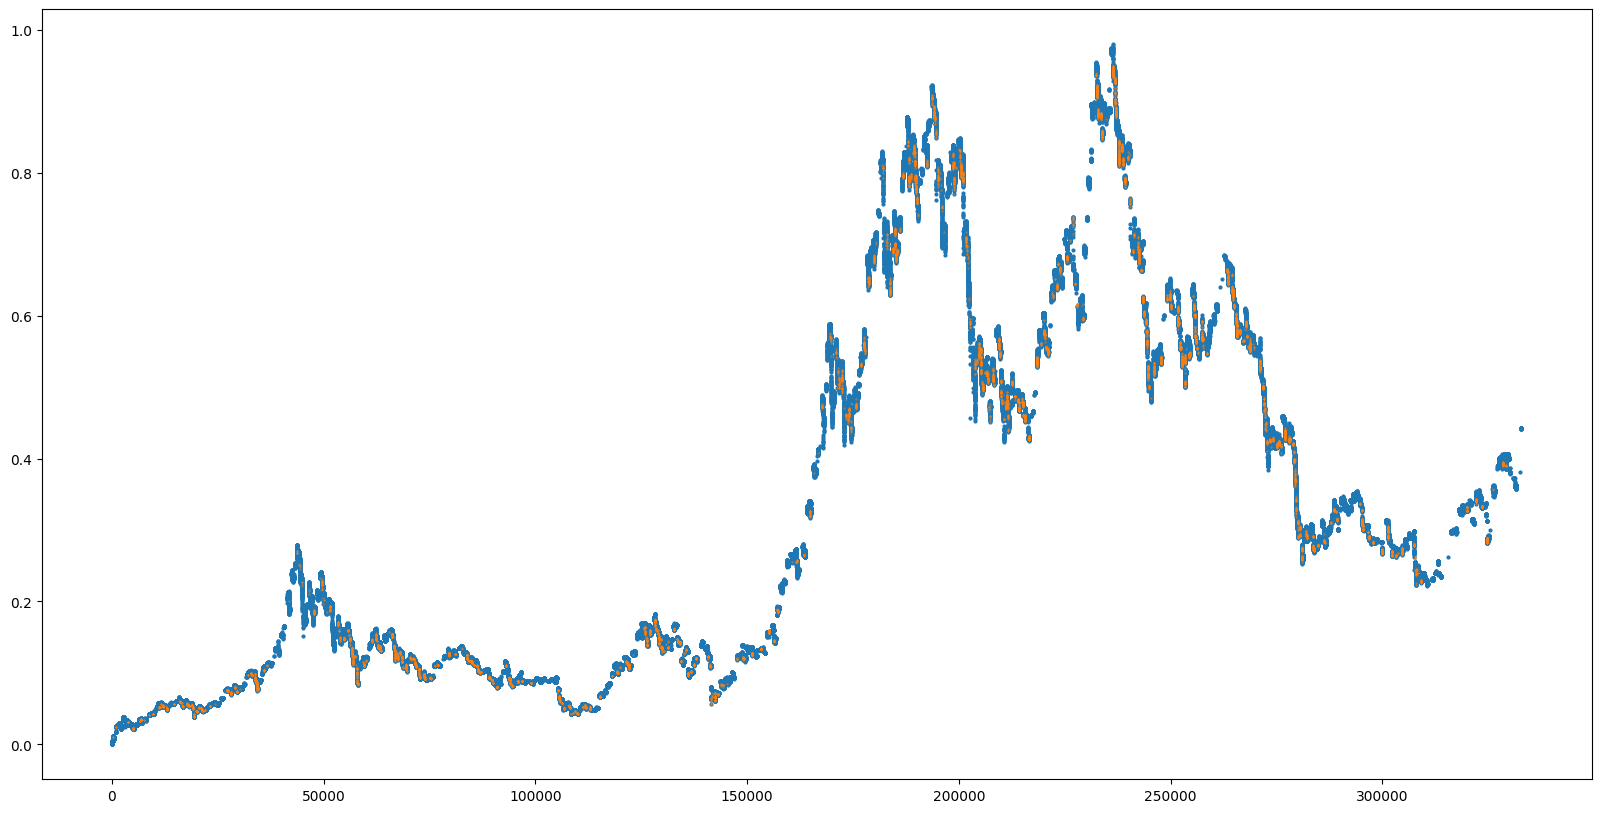

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(train_data_unshuffled[train_data_unshuffled['target']==1].index, train_data_unshuffled[train_data_unshuffled['target']==1]['close'], s=4)
plt.scatter(train_data_unshuffled[train_data_unshuffled['preds']==1].index, train_data_unshuffled[train_data_unshuffled['preds']==1]['close'], s=0.1)

In [47]:
from sklearn.metrics import confusion_matrix

confusion_matrix(train_data_unshuffled[row_range[1]:]['target'], train_data_unshuffled[row_range[1]:]['preds'])

array([[41767,     8],
       [22277,  2513]])

In [64]:
zz = pd.concat([train_data_unshuffled, my_minute_data_subset.iloc[window_size:-window_size, :][['time', 'time_step']].reset_index(drop=True)], axis=1)
zz

,close,prev,gain,loss,avg_gain_14,avg_loss_14,RSI,high_14,low_14,Stochastic,...,price_velocity_96_hours,price_prev_168_hours,price_diff_168_hours,price_velocity_168_hours,max_240_period,min_240_period,target,preds,time,time_step
0,0.001011,0.000965,0.000653,0.000000,0.002218,0.001025,0.627429,0.000908,0.000907,0.424983,...,0.559911,0.000547,0.581311,0.642353,0.000000,0.000233,0,0,1446625320000,2015-11-04 08:22
1,0.001019,0.001011,0.000268,0.000000,0.002328,0.000869,0.675919,0.000908,0.000945,0.561519,...,0.556971,0.000580,0.581252,0.637407,0.000000,0.000233,0,0,1446625620000,2015-11-04 08:27
2,0.001011,0.001019,0.000000,0.000100,0.001994,0.000911,0.630213,0.000908,0.000945,0.606936,...,0.567024,0.000583,0.581224,0.635269,0.000000,0.000233,0,0,1446625920000,2015-11-04 08:32
3,0.000995,0.001011,0.000000,0.000591,0.001897,0.001160,0.560239,0.000908,0.000966,0.500468,...,0.560991,0.000569,0.581181,0.632291,0.000000,0.000233,0,0,1446626220000,2015-11-04 08:37
4,0.000994,0.000995,0.000310,0.000000,0.001523,0.001160,0.505588,0.000908,0.000966,0.398503,...,0.561748,0.000598,0.581078,0.624187,0.000000,0.000233,0,0,1446626520000,2015-11-04 08:42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332819,0.444697,0.444885,0.000000,0.003201,0.017135,0.005892,0.693649,0.443307,0.445518,0.969962,...,0.463254,0.441549,0.585467,0.559285,0.449535,0.456254,0,0,1687610820000,2023-06-24 12:47
332820,0.444116,0.444697,0.000000,0.009905,0.017135,0.008537,0.609805,0.443307,0.445518,0.844229,...,0.461246,0.441621,0.583237,0.557003,0.449535,0.456254,0,0,1687611120000,2023-06-24 12:52
332821,0.444198,0.444116,0.001838,0.000000,0.017893,0.008466,0.622007,0.443307,0.445603,0.422763,...,0.461938,0.441545,0.583778,0.557557,0.449535,0.456254,0,0,1687611420000,2023-06-24 12:57
332822,0.444020,0.444198,0.000000,0.003046,0.016955,0.009747,0.575244,0.443307,0.445603,0.481129,...,0.461692,0.441782,0.582361,0.556105,0.449535,0.456254,0,0,1687611720000,2023-06-24 13:02


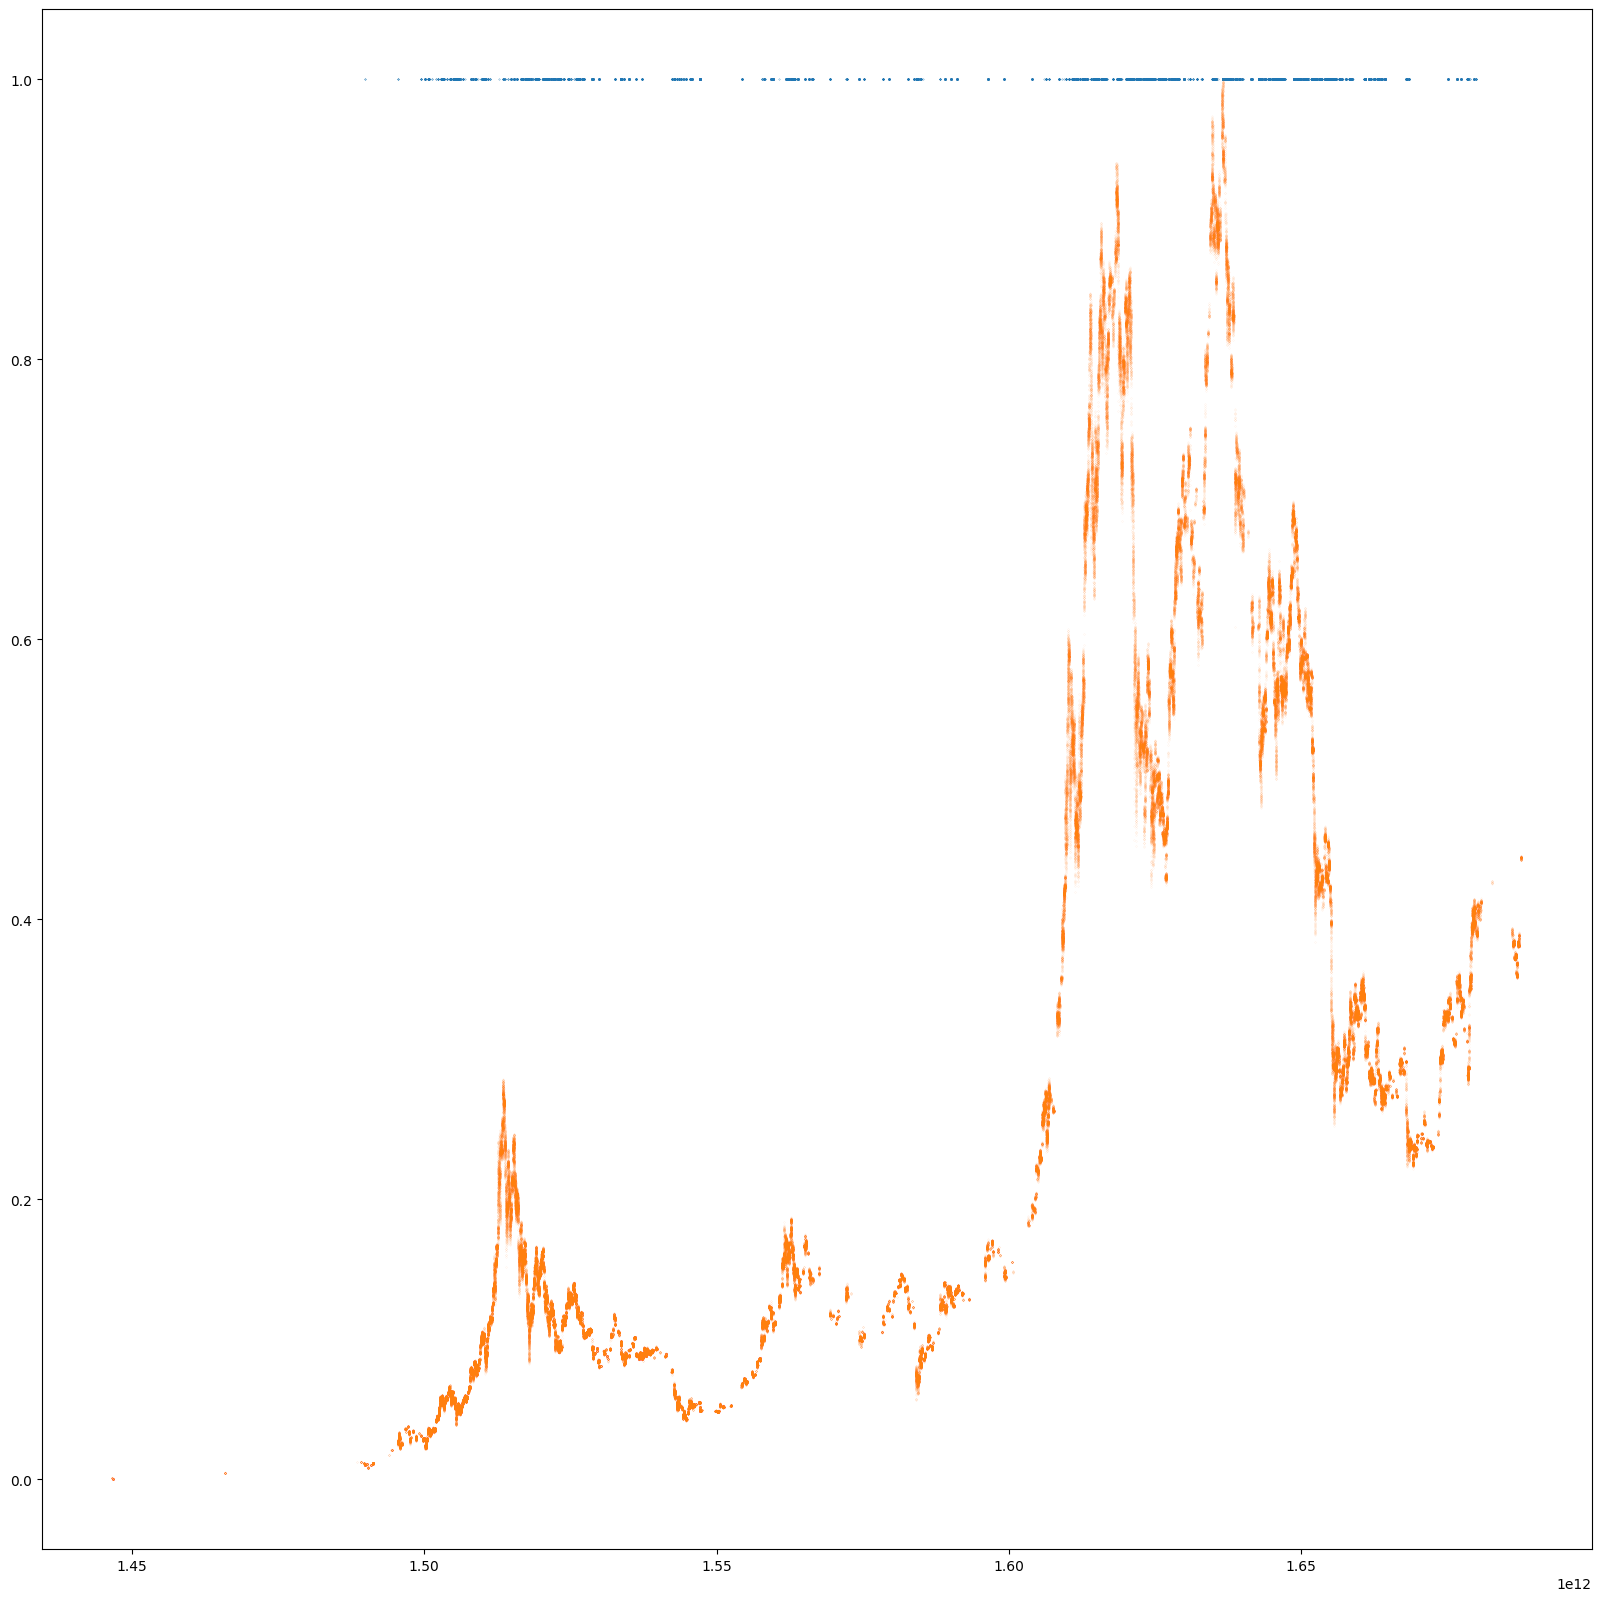

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plt.scatter(zz[zz['preds']==1]['time'], zz[zz['preds']==1]['preds'], s=0.05)
plt.scatter(zz['time'], zz['close'], s=0.001);